In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [72]:
#load dataset and init dataloader
df = pd.read_parquet("final_data_parquet.parquet")
print(df)
data = df.to_numpy()

# x_numpy = data[:,np.r_[0:2, 5:10]]
x_numpy = data[:,0:6]
y_numpy = data[:,6]
# print(x_numpy)

print(type(x_numpy))
print(type(y_numpy))

x_tensor = torch.from_numpy(x_numpy.astype(np.float32))
y_tensor = torch.from_numpy(y_numpy.astype(np.float32))

print(type(x_tensor))
print(type(y_tensor))

dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 4096
train_DL = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
print(type(train_dataset))

print(train_size)
print(test_size)

          distance  day_of_week  hour_bucket      temp    precip  wind_speed  \
0        -0.179978    -0.612504    -0.592143 -0.646645 -0.482898   -0.411618   
1        -0.176209    -0.515786    -0.393406 -0.639491  0.185643   -0.393303   
2        -0.176209    -0.515786    -0.312704 -0.639523  0.082063   -0.389406   
3        -0.176209    -0.498451    -0.554809 -0.638728 -0.041466   -0.399390   
4        -0.176209    -0.498451    -0.474108 -0.638044  0.318381   -0.397686   
...            ...          ...          ...       ...       ...         ...   
12168148 -0.010657    -0.138057    -0.430459 -0.006315  0.003082   -0.128694   
12168149 -0.010657    -0.269445     0.128419 -0.077553  0.052546   -0.015224   
12168150 -0.010657    -0.138057     0.128419  0.127475 -0.013168   -0.141301   
12168151 -0.010657    -0.269445    -0.430459 -0.016957 -0.013168   -0.090082   
12168152 -0.010657    -0.269445    -0.430459 -0.092975 -0.013168   -0.167306   

          mean_travel_time  
0         

In [73]:
#show sample
sample = next(iter(train_DL))
print('Inputs:', sample[0].shape)
print('Targets:', sample[1].shape)

Inputs: torch.Size([4096, 6])
Targets: torch.Size([4096])


In [81]:
#num features
nf = 64

#use GPU if available 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Build convolutional neural network
class Uber_reg(nn.Module):
    def __init__(self):
        super(Uber_reg, self).__init__() #init Uber_reg's superclass
        
        self.lin = nn.Sequential(
            nn.Linear(6, 64), #out 64 features
            # nn.BatchNorm2d(nf), 
            nn.LeakyReLU(0.01, inplace=True),
            
            nn.Linear(64, 32), #out 32
            # nn.BatchNorm2d(nf*2), #same as output channels
            nn.LeakyReLU(0.01, inplace=True),
            
            nn.Linear(32, 16), #out 16
            # nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.01, inplace=True),
            
            nn.Linear(16, 8), #out 8
            # nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.01, inplace=True),
            
            nn.Linear(8, 4), #out 4
            # nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.01, inplace=True),

            nn.Linear(4, 2), #out 2
            nn.LeakyReLU(0.01, inplace=True),

            nn.Linear(2, 1), #out 1
            nn.LeakyReLU(0.01, inplace=True)
        )
        
    def forward(self, x):
        # print(1, x.shape)
        #reshape for dummy data with 1 feature
        # x = x.reshape((x.shape[0], 1))
        # print(2, x.shape)
        x = self.lin(x)
        # print(3, x.shape)
        return x


In [82]:
#initialize and test network
net = Uber_reg().to(device)
print(net)
net(sample[0].to(device)).shape

Uber_reg(
  (lin): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=8, out_features=4, bias=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Linear(in_features=4, out_features=2, bias=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Linear(in_features=2, out_features=1, bias=True)
    (13): LeakyReLU(negative_slope=0.01, inplace=True)
  )
)


torch.Size([4096, 1])

In [83]:
#initialize error function and optimizer
opt = torch.optim.Adam(net.parameters(), betas=(0.9, 0.999), lr = 0.001)
error = torch.nn.MSELoss()

In [84]:
#initialize test dataloader
batch_size = 256
test_DL = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [85]:
#training parameters
epochs = 10
iters = 0
iters_cycle = 1000

#save losses
train_losses = []
test_losses = []
train_avg_losses = []
test_avg_losses = []

#train
for epoch in range(epochs):
    #set model to training mode
    net.train()
    #iterate through dataloader
    for batch in train_DL:
        #separate batch into targets and inputs
        inputs = batch[0].to(device)
        targets = batch[1]
        targets = targets.reshape((targets.shape[0], 1))
                
        #make predictions
        pred = net(inputs)
        
        #calculate loss
        loss = error(pred, targets)
        
        #backpropagate gradients with Adam algorithm
        loss.backward()
        opt.step()
        
        #set gradients to zero
        net.zero_grad()
        
        #save losses
        train_losses.append(loss.item())
        train_avg_losses.append(np.mean(train_losses))
        
        #log progress
        if iters % iters_cycle == 0:    
            print('TRAINING     Epoch: {}/{}     Iter: {}     Loss: {}'.format(epoch + 1, epochs, iters, np.mean(train_losses)))
        iters +=1

    #set model to evaluation mode
    net.eval()
    for batch in test_DL:
        #separate batch into targets and inputs
        inputs = batch[0].to(device)
        targets = batch[1].to(device)
        targets = targets.reshape((targets.shape[0], 1))
                
        #make predictions
        with torch.no_grad():
            pred = net(inputs)
        
        #calculate loss
        opt.zero_grad()
        loss = error(pred, targets)
        
        #save losses
        test_losses.append(loss.item())
        test_avg_losses.append(np.mean(test_losses))
        
        #log progress
        if iters % iters_cycle == 0:    
            print('TESTING      Epoch: {}/{}     Iter: {}     Loss: {}'.format(epoch + 1, epochs, iters, np.mean(test_losses)))
        iters +=1

TRAINING     Epoch: 1/10     Iter: 0     Loss: 1049452.25
TRAINING     Epoch: 1/10     Iter: 1000     Loss: 342071.27764423075
TRAINING     Epoch: 1/10     Iter: 2000     Loss: 225091.9556784108
TESTING      Epoch: 1/10     Iter: 3000     Loss: 104813.28486202925
TESTING      Epoch: 1/10     Iter: 4000     Loss: 104864.43297558113
TESTING      Epoch: 1/10     Iter: 5000     Loss: 104489.84835145532
TESTING      Epoch: 1/10     Iter: 6000     Loss: 104639.75013473544
TESTING      Epoch: 1/10     Iter: 7000     Loss: 104515.50754217128
TESTING      Epoch: 1/10     Iter: 8000     Loss: 104575.43937602796
TESTING      Epoch: 1/10     Iter: 9000     Loss: 104587.3672989555
TESTING      Epoch: 1/10     Iter: 10000     Loss: 104596.36232569435
TESTING      Epoch: 1/10     Iter: 11000     Loss: 104524.84192868376
TRAINING     Epoch: 2/10     Iter: 12000     Loss: 201321.20824040196
TRAINING     Epoch: 2/10     Iter: 13000     Loss: 173150.49280462938
TRAINING     Epoch: 2/10     Iter: 14000   

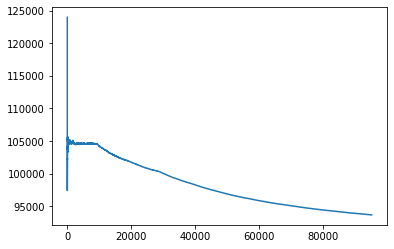

In [88]:
#plot loss curve 
# plt.plot(train_avg_losses)
plt.plot(test_avg_losses)

In [70]:
#define the path to save/load the model
model_dir = 'checkpoints/'

def save_model(model_dir):
    #saves the model state and optimizer state on the dict
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    torch.save({
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': opt.state_dict()
    }, os.path.join(model_dir, 'checkpoint.pt'))
    print('model saved at', model_dir + 'checkpoint.pt')

def load_model(model_dir, load_optimizer=False):
    #load the model from the disk if it exists, skip if you don't need this part
    if os.path.exists(model_dir):
        checkpoint = torch.load(os.path.join(model_dir, 'checkpoint.pt'))
        net.load_state_dict(checkpoint['model_state_dict'])
        if load_optimizer:
            opt.load_state_dict(checkpoint['optimizer_state_dict'])
        print('loaded model from saved checkpoint')

In [71]:
save_model(model_dir)
# load_model(model_dir)

model saved at checkpoints/checkpoint4.pt


In [106]:
#Evaluate accuracy using predictions
def testAccuracy(model, test_set, cpu = 'False'):
    #set device
    if cpu == True:
        dev = torch.device('cpu')
    else:
        dev = torch.device('cuda:0')
    model = model.to(dev)
    test_inputs = test_set[0].to(dev)
    test_targets = test_set[1].to(dev)
    
    #make predictions
    with torch.no_grad(): 
        model_pred = model(test_inputs).cpu().numpy() 
        
    #Count number of correct predictions    
    correct = 0
    total = test_targets.shape[0]
    for i, prediction in enumerate(model_pred):
        if test_targets[i]==np.argmax(prediction):
            correct += 1
            
    #revert model to global device
    model=model.to(device)
    
    #print accuracy
    return print('Accuracy across {} samples: {}%'.format(test_targets.shape[0], correct/total*100))

In [107]:
#Evaluate accuracy on test set
test_set = next(iter(test_DL))
testAccuracy(net, test_set, cpu = True)

Accuracy across 50 samples: 0.0%


In [104]:
#display sample with label and prediction
sample = next(iter(test_DL))
print('Target:', sample[1][0].item())
print('Prediction:', net(sample[0][0].to(device))[0].item())
# plt.imshow(sample[0][0,0])

Target: 1212.0
Prediction: 997.8786010742188


In [45]:
test_sample = [130, 24, 2020, 3, 12, 5, 1, 63.25, 0, 5.25, 0, 0]
test_pred = np.array([test_sample])
test_pred_tensor = torch.from_numpy(test_pred.astype(np.float32))
prediction = net(test_pred_tensor.to(device))[0].item()
print(prediction)

907.6471557617188
